In [ ]:
import requests
import csv
from datetime import datetime
import time


SEARCH_QUERIES = [
    "polusi udara jakarta", "kualitas udara jakarta", "cuaca jakarta",
    "banjir jakarta", "debu jakarta", "asap jakarta", "kabut jakarta",
    "hujan jakarta", "banjir jkt", "polusi jkt"
]

VIDEO_IDS_MANUAL = [
    "Xmd_6ZXl6lI","imlCPA5Vu2c","OGw2Jhu4KlU","fZU9Q1_GHLE",
    "kJsBTQkZV0M","Mp4hDSnpjQ4","_41KtEUiZT8","E4nuMUg96aM",
    "frPoXlkkOXM","zdhm5OuH5Qs","52BE41TcHu4","bnb8RHwortQ"
]

COMMENT_KEYWORDS = [
    "banjir","cuaca","polusi","polusi udara","debu","asap","kabut",
    "kualitas udara","hujan","angin","kotor","pabrik","abu","jkt",
    "jakarta","sungai"
]

COMMENT_KEYWORDS = [k.lower() for k in COMMENT_KEYWORDS]


def safe_get(url, params, max_retries=3, backoff=2):
    for attempt in range(max_retries):
        try:
            r = requests.get(url, params=params, timeout=20)
            if r.status_code == 200:
                return r.json()
            else:
                print(f"HTTP {r.status_code} - {r.text[:200]}")
                # if quota or forbidden, break early
                if r.status_code in (403, 400):
                    return {"error": f"HTTP {r.status_code}"}
        except Exception as e:
            print("Request error:", e)
        time.sleep(backoff * (attempt + 1))
    return {"error": "max retries"}

def search_videos(query, max_results=25):
    url = "https://www.googleapis.com/youtube/v3/search"
    params = {
        "key": API_KEY,
        "q": query,
        "part": "id",
        "maxResults": max_results,
        "type": "video"
    }
    data = safe_get(url, params)
    ids = []
    if "items" in data:
        for it in data["items"]:
            vid = it.get("id", {}).get("videoId")
            if vid:
                ids.append(vid)
    else:
        print("Search error or no items for query:", query, data.get("error"))
    return ids

def scrape_comments_for_video(video_id):
    url = "https://www.googleapis.com/youtube/v3/commentThreads"
    results = []
    page_token = None
    checked = 0
    matched = 0

    while True:
        params = {
            "key": API_KEY,
            "part": "snippet",
            "videoId": video_id,
            "maxResults": 100,
            "textFormat": "plainText"
        }
        if page_token:
            params["pageToken"] = page_token

        data = safe_get(url, params)
        if "error" in data:
            print("API error while fetching comments for", video_id, data.get("error"))
            break

        items = data.get("items", [])
        if not items and page_token is None:
            print(f"-> No commentThreads returned for video {video_id} (comments may be disabled or none).")
            break

        for it in items:
            try:
                c = it["snippet"]["topLevelComment"]["snippet"]
            except Exception:
                continue
            checked += 1
            text = c.get("textDisplay", "")
            text_l = text.lower()
            published = c.get("publishedAt")

            dt = None
            if published:
                try:
                    dt = datetime.fromisoformat(published.replace("Z", "+00:00"))
                except Exception:
                    try:
                        dt = datetime.strptime(published, "%Y-%m-%dT%H:%M:%S.%fZ")
                    except Exception:
                        dt = None

            if dt and dt.year == 2023 and any(kw in text_l for kw in COMMENT_KEYWORDS):
                matched += 1
                results.append({
                    "tanggal": dt.strftime("%Y-%m-%d"),
                    "komentar": text,
                    "video_id": video_id
                })

        page_token = data.get("nextPageToken")
        if not page_token:
            break

    return results, checked, matched

video_ids = set(VIDEO_IDS_MANUAL)

print("Searching videos from queries...")
for q in SEARCH_QUERIES:
    found = search_videos(q, max_results=25)
    for v in found:
        video_ids.add(v)

video_ids = list(video_ids)
print("Total videos to check:", len(video_ids))

all_rows = []
summary = []

for vid in video_ids:
    print("\n--- Processing video:", vid)
    rows, checked, matched = scrape_comments_for_video(vid)
    print(f"Checked comments: {checked}, Matched: {matched} for video {vid}")
    all_rows.extend(rows)
    summary.append({"video_id": vid, "checked": checked, "matched": matched})

outfile = "komentar_jakarta_2023_debug.csv"
if all_rows:
    with open(outfile, "w", newline="", encoding="utf-8-sig") as f:
        writer = csv.DictWriter(f, fieldnames=["tanggal", "komentar", "video_id"])
        writer.writeheader()
        writer.writerows(all_rows)
    print(f"\nSelesai. Disimpan: {outfile}. Total matched rows: {len(all_rows)}")
else:
    print("\nTidak ditemukan komentar yang cocok di semua video (hasil matched = 0).")
    print("Ringkasan per video (checked, matched):")
    for s in summary:
        print(f" - {s['video_id']}: checked={s['checked']}, matched={s['matched']}")


Searching videos from queries...
HTTP 403 - {
  "error": {
    "code": 403,
    "message": "YouTube Data API v3 has not been used in project 751675686458 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis
Search error or no items for query: kabut jakarta HTTP 403
HTTP 403 - {
  "error": {
    "code": 403,
    "message": "YouTube Data API v3 has not been used in project 751675686458 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis
Search error or no items for query: hujan jakarta HTTP 403
Total videos to check: 181

--- Processing video: QcGErk3JaBo
Checked comments: 1, Matched: 0 for video QcGErk3JaBo

--- Processing video: kx5fw0Midec
-> No commentThreads returned for video kx5fw0Midec (comments may be disabled or none).
Checked comments: 0, Matched: 0 for video kx5fw0Midec

--- Processing video: ZTJa6BxKdX8
Checked comments: 1, Matched: 0 for video ZTJa6BxKdX8

--- Processing video: 2J6mrTkLa6c
-> No co

SCRAPING COMENTAR YOUTUBE TENTANG RESPON PUBLIK TERHADAP CUACA DAN KUALITAS UDARA

Cleaning hasil scraping sentimen 

In [37]:
import pandas as pd
import re

data = pd.read_csv("komentar_jakarta_2023_debug.csv")

data = data.dropna(how="all")

def bersihkan_komentar(teks):
    if pd.isna(teks):
        return ""
    teks = str(teks).strip()

    teks = re.sub(r"[^a-zA-Z0-9.,!?()/%\- ]+", " ", teks)

    teks = re.sub(r"\s+", " ", teks)

    return teks.strip()


data["komentar"] = data["komentar"].apply(bersihkan_komentar)

data = data[data["komentar"] != ""]

data = data.drop_duplicates(subset=["tanggal", "komentar"])

kelompok_tanggal = data.groupby("tanggal")["komentar"].apply(list).reset_index()


maksimal_isi = kelompok_tanggal["komentar"].apply(len).max()

for i in range(maksimal_isi):
    kelompok_tanggal[f"sentimen_{i+1}"] = kelompok_tanggal["komentar"].apply(
        lambda daftar: daftar[i] if i < len(daftar) else ""
    )

kelompok_tanggal = kelompok_tanggal.drop(columns=["komentar"])
display(kelompok_tanggal.head())


kelompok_tanggal.to_csv("data_sentimen_bersih.csv", index=False)


,tanggal,sentimen_1,sentimen_2,sentimen_3,sentimen_4,sentimen_5,sentimen_6,sentimen_7,sentimen_8,sentimen_9,sentimen_10,sentimen_11,sentimen_12,sentimen_13,sentimen_14,sentimen_15,sentimen_16,sentimen_17,sentimen_18,sentimen_19,sentimen_20,sentimen_21,sentimen_22,sentimen_23,sentimen_24,sentimen_25,sentimen_26,sentimen_27,sentimen_28,sentimen_29,sentimen_30,sentimen_31,sentimen_32,sentimen_33,sentimen_34,sentimen_35,sentimen_36,sentimen_37,sentimen_38,sentimen_39,sentimen_40,sentimen_41,sentimen_42,sentimen_43,sentimen_44,sentimen_45,sentimen_46,sentimen_47,sentimen_48,sentimen_49,sentimen_50,sentimen_51,sentimen_52,sentimen_53,sentimen_54,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63
0,2023-01-04,"Hujan itu berkah, bukan musibah apalgi bencana...",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2023-01-13,Dan Akhirnya Panasss terik bak musim kemarau.....,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2023-02-03,Mbak Nana maen ke Jambi dong mbak Nanan pengan...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2023-02-23,Kredibel KLH di pertanyakan sebab hasil analis...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,2023-05-29,Sejak DKI Jakarta sudah tidak dijabat Anies Ba...,Pengusaha batu bara berhasil berada di posisi ...,Anis tuh yg bikin polusi,Udah kumuh busuk gak tertata rapi banyak sampa...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


CLEANING CUACA

In [12]:
import pandas as pd

df = pd.read_excel('dataset_prediksi_cuaca.xlsx')

df.columns = df.columns.str.strip()

df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)

kolom_numerik = [
    'Suhu Maks (deg of C)', 'Suhu Min (deg of C)', 'Kelembaban (%)',
    'Kecepatan Angin (km/jam)', 'Arah Angin (deg)', 'Tekanan Udara (hPa)',
    'Tutupan Awan (%)', 'Curah Hujan Hari Ini (mm)', 'Curah Hujan Besok (mm)'
]

for kolom in kolom_numerik:
    df[kolom] = df[kolom].astype(str).str.replace(',', '.', regex=False)
    df[kolom] = pd.to_numeric(df[kolom], errors='coerce')

df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

df_2023 = df[df['Tanggal'].dt.year == 2023]


df_2023 = df_2023.drop_duplicates()
df_2023 = df_2023.dropna(subset=['Tanggal'])
df_2023.to_csv("data_cuaca_jakarta_2023_bersih.csv", index=False)

display(df_2023.head())




C:\Users\Bima Sena\AppData\Local\Temp\ipykernel_18680\3230183737.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


,Tanggal,Lokasi,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Arah Angin (deg),Tekanan Udara (hPa),Tutupan Awan (%),Curah Hujan Hari Ini (mm),Cuaca Hari Ini,Curah Hujan Besok (mm),Cuaca Besok
1461,2023-01-01,Jakarta,30.9,25.2,82,17.3,221.0,1011.2,24,0.0,Cerah Berawan,15.1,Hujan Sedang
1462,2023-01-02,Jakarta,27.6,23.3,76,9.5,136.5,1010.4,59,15.1,Hujan Sedang,10.5,Hujan Sedang
1463,2023-01-03,Jakarta,27.9,23.5,85,8.7,51.1,1009.1,97,10.5,Hujan Sedang,0.0,Cerah
1464,2023-01-04,Jakarta,28.6,24.1,53,6.7,0.7,1003.3,53,0.0,Cerah,0.0,Cerah Berawan
1465,2023-01-05,Jakarta,28.6,23.6,83,11.6,161.2,1014.3,50,0.0,Cerah Berawan,0.0,Cerah


CLEANING DATA KUALITAS UDARA

In [10]:
import pandas as pd
import re

data = pd.read_csv("ispu_dki4.csv")

data.columns = data.columns.str.strip().str.lower()

def bersihkan_teks(teks):
    if pd.isna(teks):
        return ""
    teks = str(teks).strip()
    teks = re.sub(r"[^0-9a-zA-Z.,()\-/% ]+", " ", teks)
    teks = re.sub(r"\s+", " ", teks)
    return teks

kolom_teks = ["stasiun", "critical", "categori"]

for kolom in kolom_teks:
    data[kolom] = data[kolom].apply(bersihkan_teks)


kolom_angka = ["pm25","pm10","so2","co","o3","no2","max"]

for kolom in kolom_angka:
    data[kolom] = (
        data[kolom]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
    )
    data[kolom] = pd.to_numeric(data[kolom], errors="coerce")


data["tanggal"] = pd.to_datetime(data["tanggal"], errors="coerce")


data = data.dropna(subset=["tanggal"])
data = data.drop_duplicates()

display(data.head())
data.to_csv("kualitas_udara_jakarta_2023_bersih.csv", index=False)



,unnamed: 0,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori
0,4383,2023-01-01,DKI4 (Lubang Buaya),57.0,23.0,NaN,NaN,NaN,NaN,57.0,PM25,SEDANG
1,4384,2023-01-02,DKI4 (Lubang Buaya),53.0,27.0,53.0,3.0,12.0,10.0,53.0,PM25,SEDANG
2,4385,2023-01-03,DKI4 (Lubang Buaya),43.0,19.0,53.0,3.0,11.0,9.0,53.0,SO2,SEDANG
3,4386,2023-01-04,DKI4 (Lubang Buaya),51.0,17.0,53.0,4.0,9.0,10.0,53.0,SO2,SEDANG
4,4387,2023-01-05,DKI4 (Lubang Buaya),59.0,21.0,53.0,19.0,14.0,11.0,59.0,PM25,SEDANG


INTEGRASI BERDASARKAN TANGGAL

In [ ]:
import pandas as pd

data_sentimen = pd.read_csv("data_sentimen_bersih.csv")
data_cuaca = pd.read_csv("data_cuaca_jakarta_2023_bersih.csv")
data_udara = pd.read_csv("kualitas_udara_jakarta_2023_bersih.csv")


data_sentimen["tanggal"] = pd.to_datetime(data_sentimen["tanggal"], errors="coerce")

data_cuaca["tanggal"] = pd.to_datetime(data_cuaca["Tanggal"], errors="coerce")

data_udara["tanggal"] = pd.to_datetime(data_udara["tanggal"], errors="coerce")

data_cuaca = data_cuaca.drop(columns=["Tanggal"])

gabung_cuaca_udara = pd.merge(
    data_cuaca,
    data_udara,
    on="tanggal",
    how="left"
)

gabungan_akhir = pd.merge(
    gabung_cuaca_udara,
    data_sentimen,
    on="tanggal",
    how="left"
)


if "tanggal" not in gabungan_akhir.columns:
    raise ValueError("Kolom 'tanggal' hilang. Periksa merge.")

gabungan_akhir = gabungan_akhir.sort_values("tanggal")

kolom_akhir = ["tanggal"] + [col for col in gabungan_akhir.columns if col != "tanggal"]
gabungan_akhir = gabungan_akhir[kolom_akhir]

for kol in ["unnamed: 0", "Unnamed: 0"]:
    if kol in gabungan_akhir.columns:
        gabungan_akhir = gabungan_akhir.drop(columns=[kol])

gabungan_akhir.to_csv("integrasi_cuaca_udara_sentimen_2023.csv", index=False)


display(gabungan_akhir.head())

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


print("\nJumlah baris:", len(gabungan_akhir))


Contoh data integrasi:


,tanggal,Lokasi,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Arah Angin (deg),Tekanan Udara (hPa),Tutupan Awan (%),Curah Hujan Hari Ini (mm),Cuaca Hari Ini,Curah Hujan Besok (mm),Cuaca Besok,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori,sentimen_1,sentimen_2,sentimen_3,sentimen_4,sentimen_5,sentimen_6,sentimen_7,sentimen_8,sentimen_9,sentimen_10,sentimen_11,sentimen_12,sentimen_13,sentimen_14,sentimen_15,sentimen_16,sentimen_17,sentimen_18,sentimen_19,sentimen_20,sentimen_21,sentimen_22,sentimen_23,sentimen_24,sentimen_25,sentimen_26,sentimen_27,sentimen_28,sentimen_29,sentimen_30,sentimen_31,sentimen_32,sentimen_33,sentimen_34,sentimen_35,sentimen_36,sentimen_37,sentimen_38,sentimen_39,sentimen_40,sentimen_41,sentimen_42,sentimen_43,sentimen_44,sentimen_45,sentimen_46,sentimen_47,sentimen_48,sentimen_49,sentimen_50,sentimen_51,sentimen_52,sentimen_53,sentimen_54,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63
0,2023-01-01,Jakarta,30.9,25.2,82,17.3,221.0,1011.2,24,0.0,Cerah Berawan,15.1,Hujan Sedang,DKI4 (Lubang Buaya),57.0,23.0,NaN,NaN,NaN,NaN,57.0,PM25,SEDANG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,Jakarta,27.6,23.3,76,9.5,136.5,1010.4,59,15.1,Hujan Sedang,10.5,Hujan Sedang,DKI4 (Lubang Buaya),53.0,27.0,53.0,3.0,12.0,10.0,53.0,PM25,SEDANG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,Jakarta,27.9,23.5,85,8.7,51.1,1009.1,97,10.5,Hujan Sedang,0.0,Cerah,DKI4 (Lubang Buaya),43.0,19.0,53.0,3.0,11.0,9.0,53.0,SO2,SEDANG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,Jakarta,28.6,24.1,53,6.7,0.7,1003.3,53,0.0,Cerah,0.0,Cerah Berawan,DKI4 (Lubang Buaya),51.0,17.0,53.0,4.0,9.0,10.0,53.0,SO2,SEDANG,"Hujan itu berkah, bukan musibah apalgi bencana...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,Jakarta,28.6,23.6,83,11.6,161.2,1014.3,50,0.0,Cerah Berawan,0.0,Cerah,DKI4 (Lubang Buaya),59.0,21.0,53.0,19.0,14.0,11.0,59.0,PM25,SEDANG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Jumlah baris: 365


GROUPING RATA2 POLUTEN BERDASARKAN LOKASI DAN RATA2 CUACA PERTANGGA;

In [ ]:
import pandas as pd

df_final = pd.read_csv("integrasi_cuaca_udara_sentimen_2023.csv")

df_final["tanggal"] = pd.to_datetime(df_final["tanggal"], errors="coerce")


group_lokasi = df_final.groupby("Lokasi")[["pm25", "pm10", "so2", "co", "o3", "no2"]].mean()

print("\n Rata-rata polutan jakaerta")
display(group_lokasi)

group_tanggal = df_final.groupby("tanggal")[[
    "Suhu Maks (deg of C)",
    "Suhu Min (deg of C)",
    "Kelembaban (%)",
    "Kecepatan Angin (km/jam)",
    "Tekanan Udara (hPa)"
]].mean()

print("\nRata-rata cuaca per tanggal ")
display(group_tanggal)



 Rata-rata polutan jakaerta


,pm25,pm10,so2,co,o3,no2
Lokasi,,,,,,
Jakarta,94.703081,59.32973,35.960563,17.745042,19.033708,15.363128



Rata-rata cuaca per tanggal 


,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Tekanan Udara (hPa)
tanggal,,,,,
2023-01-01,30.9,25.2,82.0,17.3,1011.2
2023-01-02,27.6,23.3,76.0,9.5,1010.4
2023-01-03,27.9,23.5,85.0,8.7,1009.1
2023-01-04,28.6,24.1,53.0,6.7,1003.3
2023-01-05,28.6,23.6,83.0,11.6,1014.3
...,...,...,...,...,...
2023-12-27,31.9,27.6,75.0,12.1,1005.4
2023-12-28,27.9,22.6,66.0,9.0,1012.4
2023-12-29,30.4,25.2,71.0,7.2,1007.3


SORTING 10 HARI BERDASARKAN POLUTAN,SUHU MAX DAN SENTIMEN TETINGGI

In [63]:
import pandas as pd


df_final = pd.read_csv("integrasi_cuaca_udara_sentimen_2023.csv")
df_final["tanggal"] = pd.to_datetime(df_final["tanggal"], errors="coerce")

sentimen_cols = [col for col in df_final.columns if col.startswith("sentimen_")]

df_final["total_sentimen"] = df_final[sentimen_cols].count(axis=1)  

cols_show = [
    "tanggal", "Lokasi",
    "Suhu Maks (deg of C)", "Suhu Min (deg of C)",
    "Kelembaban (%)", "Kecepatan Angin (km/jam)",
    "Tekanan Udara (hPa)",
    "pm25", "pm10", "so2", "co", "o3", "no2",
    "total_sentimen"
] + sentimen_cols

sort_pm25 = df_final.sort_values("pm25", ascending=False)
print(" 10 Hari Dengan PM2.5 Tertinggi ")
display(sort_pm25[cols_show].head(10))


sort_temp = df_final.sort_values("Suhu Maks (deg of C)", ascending=False)
print("10 Hari Dengan Suhu Maks Tertinggi ")
display(sort_temp[cols_show].head(10))


sort_sentimen = df_final.sort_values("total_sentimen", ascending=False)
print("10 Hari Dengan Jumlah Respons Publik Terbanyak ")
display(sort_sentimen[cols_show].head(10))


 10 Hari Dengan PM2.5 Tertinggi 


,tanggal,Lokasi,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Tekanan Udara (hPa),pm25,pm10,so2,co,o3,no2,total_sentimen,sentimen_1,sentimen_2,sentimen_3,sentimen_4,sentimen_5,sentimen_6,sentimen_7,sentimen_8,sentimen_9,sentimen_10,sentimen_11,sentimen_12,sentimen_13,sentimen_14,sentimen_15,sentimen_16,sentimen_17,sentimen_18,sentimen_19,sentimen_20,sentimen_21,sentimen_22,sentimen_23,sentimen_24,sentimen_25,sentimen_26,sentimen_27,sentimen_28,sentimen_29,sentimen_30,sentimen_31,sentimen_32,sentimen_33,sentimen_34,sentimen_35,sentimen_36,sentimen_37,sentimen_38,sentimen_39,sentimen_40,sentimen_41,sentimen_42,sentimen_43,sentimen_44,sentimen_45,sentimen_46,sentimen_47,sentimen_48,sentimen_49,sentimen_50,sentimen_51,sentimen_52,sentimen_53,sentimen_54,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63
270,2023-09-28,Jakarta,33.0,27.9,74,6.0,1019.4,287.0,163.0,29.0,17.0,29.0,19.0,1,Perasaan selama ini polusi di Jakarta gak para...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,2023-09-26,Jakarta,35.0,29.8,75,11.1,1010.0,249.0,85.0,28.0,18.0,26.0,20.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2023-09-27,Jakarta,32.7,26.4,57,9.8,1004.1,217.0,NaN,28.0,22.0,23.0,22.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,2023-10-01,Jakarta,34.5,28.1,80,8.6,1004.8,199.0,126.0,29.0,26.0,27.0,25.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,2023-05-24,Jakarta,30.8,23.8,87,11.1,1014.1,170.0,NaN,38.0,35.0,17.0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353,2023-12-20,Jakarta,31.4,27.4,79,10.3,1006.3,154.0,85.0,52.0,10.0,11.0,13.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,2023-09-12,Jakarta,32.3,25.8,77,9.4,1017.2,152.0,81.0,27.0,19.0,19.0,19.0,2,"plta adalah energi bersih, pltu, pltd, pltn, s...","Ky pabriknya kaido, mencemari lingkungan dan r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,2023-07-11,Jakarta,37.3,30.3,62,14.6,1013.2,151.0,NaN,40.0,29.0,14.0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,2023-10-29,Jakarta,32.5,25.7,71,4.7,1006.4,150.0,94.0,30.0,20.0,25.0,16.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

10 Hari Dengan Suhu Maks Tertinggi 


,tanggal,Lokasi,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Tekanan Udara (hPa),pm25,pm10,so2,co,o3,no2,total_sentimen,sentimen_1,sentimen_2,sentimen_3,sentimen_4,sentimen_5,sentimen_6,sentimen_7,sentimen_8,sentimen_9,sentimen_10,sentimen_11,sentimen_12,sentimen_13,sentimen_14,sentimen_15,sentimen_16,sentimen_17,sentimen_18,sentimen_19,sentimen_20,sentimen_21,sentimen_22,sentimen_23,sentimen_24,sentimen_25,sentimen_26,sentimen_27,sentimen_28,sentimen_29,sentimen_30,sentimen_31,sentimen_32,sentimen_33,sentimen_34,sentimen_35,sentimen_36,sentimen_37,sentimen_38,sentimen_39,sentimen_40,sentimen_41,sentimen_42,sentimen_43,sentimen_44,sentimen_45,sentimen_46,sentimen_47,sentimen_48,sentimen_49,sentimen_50,sentimen_51,sentimen_52,sentimen_53,sentimen_54,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63
191,2023-07-11,Jakarta,37.3,30.3,62,14.6,1013.2,151.0,NaN,40.0,29.0,14.0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,2023-10-31,Jakarta,36.4,29.8,76,5.5,1013.9,108.0,81.0,29.0,22.0,33.0,20.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,2023-05-08,Jakarta,36.3,29.4,79,9.0,1008.1,88.0,NaN,34.0,34.0,21.0,20.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,2023-08-03,Jakarta,36.3,31.3,60,9.9,1008.1,106.0,NaN,28.0,21.0,22.0,14.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,2023-07-05,Jakarta,36.3,31.0,82,5.7,1015.8,119.0,NaN,39.0,31.0,22.0,16.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,2023-08-10,Jakarta,36.0,30.6,53,7.5,1008.3,102.0,NaN,26.0,16.0,32.0,10.0,8,Ini pertanda penjabat gubernur tidak bekerja d...,alloh itu maha adil kabut itu sebagae peringat...,"Mesti segera realisasi wacana bagi jam kerja, ...",Sejak diJabat Gub Giveaway makin kacau Jakarta,Untuk mengatasinya perlu dibuat KTP Udara DKI ...,Boro2 urus solusi polusi di Tangsel..urusin ta...,Solusinya angin dari selatan di bikin flow lew...,Jadi gak heran jangan kira warga jakarta pake ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,2023-06-04,Jakarta,36.0,29.4,74,6.0,1009.2,117.0,NaN,38.0,24.0,21.0,13.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2023-05-27,Jakarta,36.0,29.9,80,8.2,1009.9,139.0,NaN,38.0,23.0,22.0,12.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,2023-05-29,Jakarta,36.0,30.2,75,8.4,1009.6,126.0,NaN,37.0,32.0,19.0,15.0,4,Se

10 Hari Dengan Jumlah Respons Publik Terbanyak 


,tanggal,Lokasi,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Tekanan Udara (hPa),pm25,pm10,so2,co,o3,no2,total_sentimen,sentimen_1,sentimen_2,sentimen_3,sentimen_4,sentimen_5,sentimen_6,sentimen_7,sentimen_8,sentimen_9,sentimen_10,sentimen_11,sentimen_12,sentimen_13,sentimen_14,sentimen_15,sentimen_16,sentimen_17,sentimen_18,sentimen_19,sentimen_20,sentimen_21,sentimen_22,sentimen_23,sentimen_24,sentimen_25,sentimen_26,sentimen_27,sentimen_28,sentimen_29,sentimen_30,sentimen_31,sentimen_32,sentimen_33,sentimen_34,sentimen_35,sentimen_36,sentimen_37,sentimen_38,sentimen_39,sentimen_40,sentimen_41,sentimen_42,sentimen_43,sentimen_44,sentimen_45,sentimen_46,sentimen_47,sentimen_48,sentimen_49,sentimen_50,sentimen_51,sentimen_52,sentimen_53,sentimen_54,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63
309,2023-11-06,Jakarta,29.8,24.6,74,9.4,1008.7,92.0,67.0,30.0,43.0,NaN,19.0,63,Hello NORMALISASI ? Yg perlu di normalisasi it...,Tenggelamkan jakarta,Selalu teringat ucapan beliau KALAU SAYA JADI ...,Banjir? Tenggelempun Gak heran kok. Masih aja ...,Dicari calon gubernur yg mampu mengatasi banji...,Dulu tempat ini selama anis mimpin gk banjir s...,anies mana anies... org itu yg bilang Tanah JK...,"Tuhan serba salah sama warga ibukota Konoha, h...",Peduli amad banjir yg penting punya stadiun baru,"siapa bilang itu banjir, itu air lagi parkir a...",Ini ibukota tpi pemukiman y sama seperti di ka...,Kalau banjir itu peninggalan anis kalau gak ba...,sejak anis jadi gubernur DKI semaking sering b...,"Di kasih ujan ngeluh akibat banjir,di kasih ke...","Enak nya bs mandi sepuas nya, di tmpt kami blm...","Yah baru juga hujan sekali,belom klo musim huj...",Banjir akan terus terjadi jika tidak ada kesad...,Kata pak Anis bukan banjir tapi Air pakir saja,Banjir ... untung Anis udah ga jadi gubernur ....,Bud.. !!! Ayo bud... Idemu opo biar jakarta ga...,Dari dulu ya udah banjir. Ya biar ngak banjir ...,"Kemarau kekeringan, hujan kebanjiran, SABAR ya...",Oalah alah angen angen jalok udan kok yo keban...,Banjir mah biasa aja. Yang penting lanjutkan b...,Katanya jakarta sudah bebas banjir.....bersih ...,Air yg turun dari atas/air hujan bisa dimasuka...,"Syukuri saja buat semua warga, sebab ituy adal...",Dulu setiap gubenur jakarta selalu di hujat da...,Katanya PJ HERU BERHASIL DI DKI JAKARTA...? Lh...,"Jkt timur mh aman hujan jarang dan alakadarnya ,","mana nih gubenurnya.. gk kerja banget,.. makan...","Siapa pelakunya sampai Jakarta banjir ,tolong ...","Gak bener Anies, Jakarta , sampe banjir gitu...",Wadudududuhhh... ininih ..hasil kerja kerja gu...,Bahagianya Cebong lstana kesampaian juga akhir...,Bukan banjir itu tapi parkir air,Ini pasti salah Pak Anis kata cebong dongok wk...,Air hujan turun dari LANGIT dan diserap oleh t...,Sip udah hujan lagi,Kagen banjir udah lama. Ga ke temu air ujan,KECEBONG KADRUN PALING SENANG KLO JAKARTA BANJ...,Kemarau salah hujan jg salah,Sama dimana mana juga .kita harys bersyukur de...,"Masih banjirrrr jakarta, ciloko ciloko.",jokowi tak becus memilih pejabat gubernur jaka...,Ayooo ngurusss banjir jgn ngurusin negara lain,Banjir itu bgus,Alhamdulillahnya polusi berkurang,Klu gubernurnya Anies banjir gini pasti rame,Santai masih ada sumur resapan andalan jakarta...,Gua ngerasain banget jakarta beda pas musim hu...,"Ya resapan sudah banyak yg d hilangkan , terim...",Alhamdulillah sudah hujan gak kekeringan lagi,"Pantes ibukota mau dipindah ikn, jakarta uda p...",Buka matamu. Stelah PK Anis brheti jdi gubernu...,"jaman anis aman, walau ada banjir sangat cepat...",Wajar banjir juga. Wong skrng jakarta gak ada ...,Giliran mas budi jadi bulan bulanan Rakyat jak...,Jakarta entar lagi tenggelam...ni ulah para pe...,"SERBA SALAH DI JKT, PAS PANAS BNYK POLUSI , PA...",Msh inget ad yg memberikan gagasan calon guber...,Ko sekarang banjir di jakarta gk pada keluar c...,Salah satu contoh maju nya jakarta yg dipimpin...
225,2023-08-14,Jak

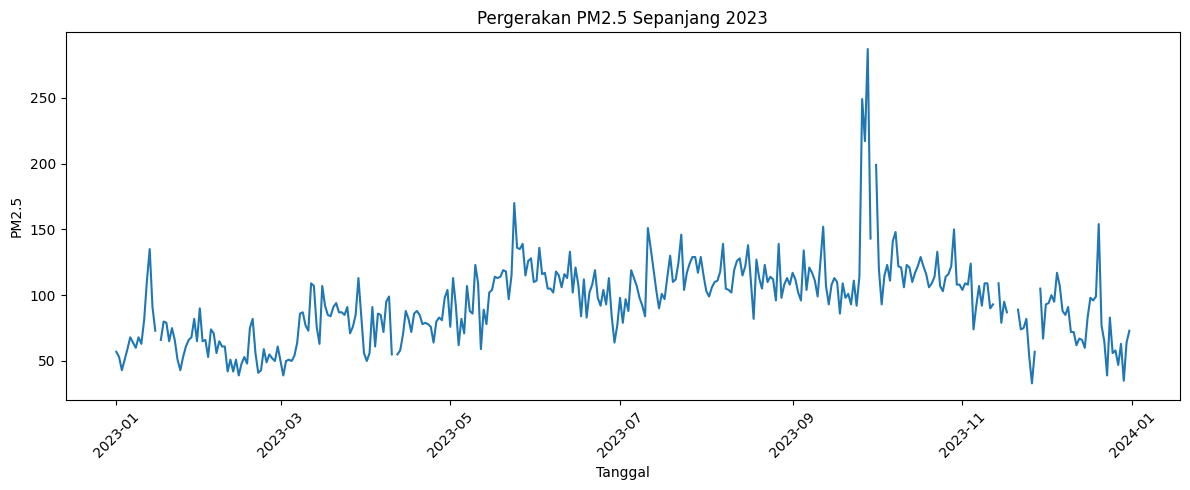

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_final["tanggal"], df_final["pm25"])
plt.title("Pergerakan PM2.5 Sepanjang 2023")
plt.xlabel("Tanggal")
plt.ylabel("PM2.5")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


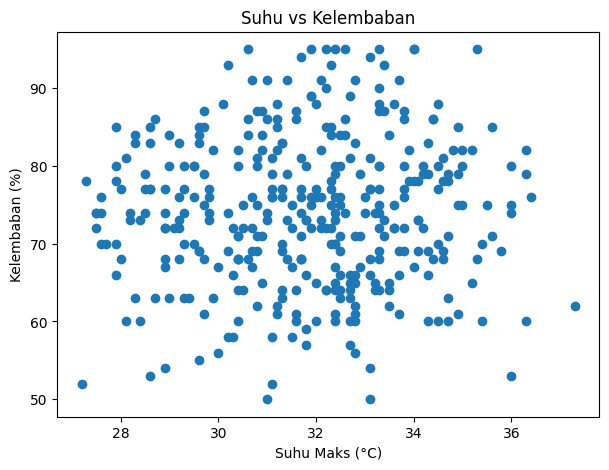

In [32]:
plt.figure(figsize=(7,5))
plt.scatter(df_final["Suhu Maks (deg of C)"], df_final["Kelembaban (%)"])
plt.title("Suhu vs Kelembaban")
plt.xlabel("Suhu Maks (°C)")
plt.ylabel("Kelembaban (%)")
plt.show()


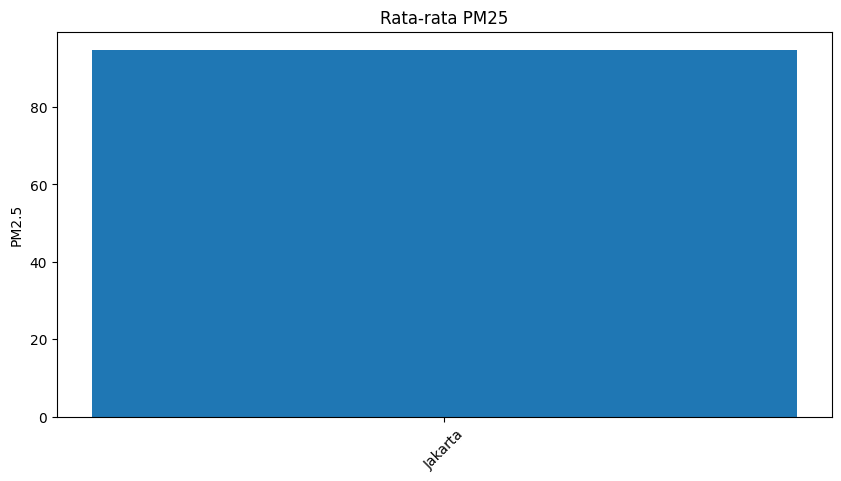

In [64]:
group_pm25 = df_final.groupby("Lokasi")["pm25"].mean()

plt.figure(figsize=(10,5))
plt.bar(group_pm25.index, group_pm25.values)
plt.title("Rata-rata PM25")
plt.xticks(rotation=45)
plt.ylabel("PM2.5")
plt.show()


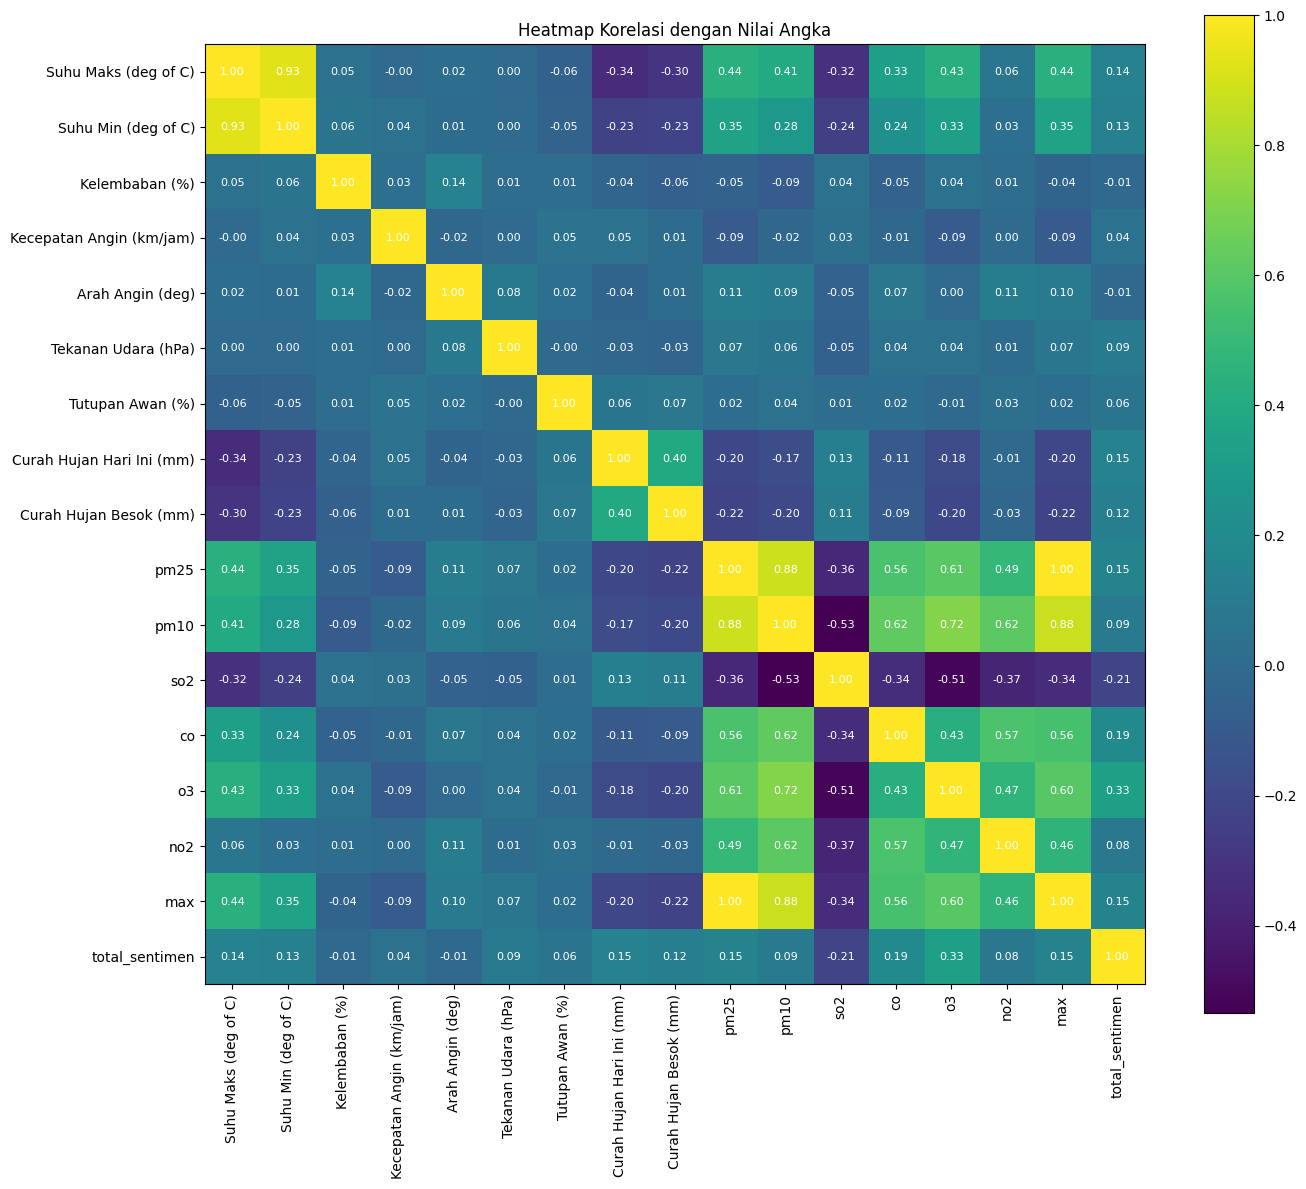

In [58]:
import matplotlib.pyplot as plt
import numpy as np

kolom_numerik = df_final.select_dtypes(include="number")
corr = kolom_numerik.corr()

plt.figure(figsize=(14, 12))
plt.imshow(corr, cmap="viridis")

plt.colorbar()

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Heatmap Korelasi dengan Nilai Angka")


for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()


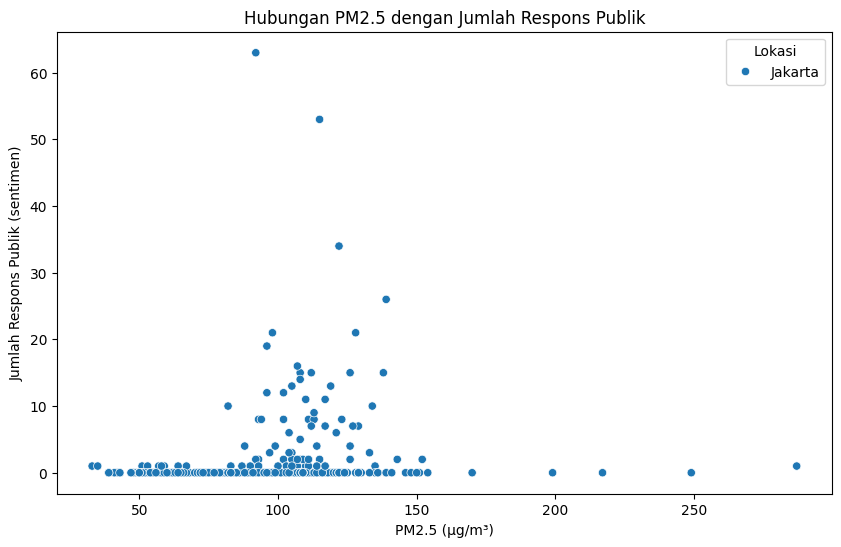

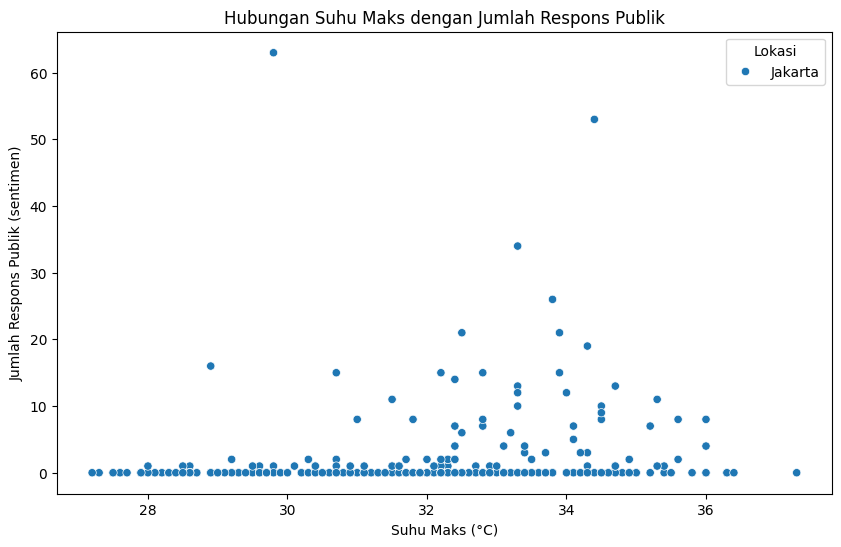

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("integrasi_cuaca_udara_sentimen_2023.csv")
df["tanggal"] = pd.to_datetime(df["tanggal"], errors="coerce")

sentimen_cols = [col for col in df.columns if col.startswith("sentimen_")]

df["total_sentimen"] = df[sentimen_cols].notna().sum(axis=1)

df_plot = df.dropna(subset=["pm25", "total_sentimen"])
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_plot, x="pm25", y="total_sentimen", hue="Lokasi", palette="tab10")
plt.title("Hubungan PM2.5 dengan Jumlah Respons Publik")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Jumlah Respons Publik (sentimen)")
plt.show()

df_plot = df.dropna(subset=["Suhu Maks (deg of C)", "total_sentimen"])
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_plot, x="Suhu Maks (deg of C)", y="total_sentimen", hue="Lokasi", palette="tab10")
plt.title("Hubungan Suhu Maks dengan Jumlah Respons Publik")
plt.xlabel("Suhu Maks (°C)")
plt.ylabel("Jumlah Respons Publik (sentimen)")
plt.show()
